In [1]:
import os, sys
import fire
import numpy as np
import lsst.daf.butler as dafButler
from unagi import hsc
s20a = hsc.Hsc(dr='dr3', rerun='s20a_wide')
sys.path.append(os.path.join(os.getenv('LAMBO_HOME'), 'lambo/scripts/'))
from hsc_gaap.gaap import findReducedPatches

# Get table list from /projects/HSC/LSST/stack_20220527/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/unagi/data/s20a_wide/s20a_wide_tables.fits
Overriding default configuration file with /projects/HSC/LSST/stack_20220527/conda/envs/lsst-scipipe-4.1.0/share/eups/Linux64/dustmaps_cachedata/g41a3ec361e+62d12e78cb/config/.dustmapsrc


In [2]:
from astropy.table import Table

In [3]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [15]:
tract = 8280
patch = 63
patch = [patch%9, patch//9]

In [16]:
gaapCat = Table.read(f"/scratch/gpfs/am2907/Merian/gaap/S20A/gaapTable/{tract}/{patch[0]},{patch[1]}/objectTable_{tract}_{patch[0]},{patch[1]}_S20A.fits")

In [17]:
gaapCat

objectId,refFwhm,refBand,detect_isIsolated,coord_dec,sky_object,shape_xy,refExtendedness,coord_ra,deblend_nChild,detect_isDeblendedSource,footprintArea,shape_flag,detect_isTractInner,detect_fromBlend,detect_isDeblendedModelSource,parentObjectId,shape_yy,detect_isPatchInner,merge_peak_sky,shape_xx,deblend_skipped,ebv,detect_isPrimary,g_ra,g_decl,g_psfFlux,g_psfFluxErr,g_free_psfFlux,g_free_psfFluxErr,g_free_psfFlux_flag,g_bdE1,g_bdE2,g_bdReB,g_bdReD,g_bdChi2,g_bdFluxB,g_bdFluxBErr,g_bdFluxD,g_bdFluxDErr,g_gaapPsfFlux,g_gaapPsfFluxErr,g_gaap0p5Flux,g_gaap0p5FluxErr,g_gaap0p7Flux,g_gaap0p7FluxErr,g_gaap0p8Flux,g_gaap0p8FluxErr,g_gaap0p9Flux,g_gaap0p9FluxErr,g_gaap1p0Flux,g_gaap1p0FluxErr,g_gaap1p2Flux,g_gaap1p2FluxErr,g_gaap1p4Flux,g_gaap1p4FluxErr,g_gaap1p5Flux,g_gaap1p5FluxErr,g_gaap2p0Flux,g_gaap2p0FluxErr,g_gaap2p5Flux,g_gaap2p5FluxErr,g_gaap3p0Flux,g_gaap3p0FluxErr,g_gaap3p5Flux,g_gaap3p5FluxErr,g_gaapOptimalFlux,g_gaapOptimalFluxErr,g_ixx,g_iyy,g_ixy,g_i_flag,g_ixxPSF,g_iyyPSF,g_ixyPSF,g_iPSF_flag,g_ixxRound,g_iyyRound,g_ixyRound,g_iRound_flag,g_ixxDebiasedPSF,g_iyyDebiasedPSF,g_ixyDebiasedPSF,g_iDebiasedPSF_flag,g_kronRad,g_kronFlux,g_kronFluxErr,g_calibFlux,g_calibFluxErr,g_ap03Flux,g_ap03FluxErr,g_ap03Flux_flag,g_ap06Flux,g_ap06FluxErr,g_ap06Flux_flag,g_ap09Flux,g_ap09FluxErr,g_ap09Flux_flag,g_ap12Flux,g_ap12FluxErr,g_ap12Flux_flag,g_ap17Flux,g_ap17FluxErr,g_ap17Flux_flag,g_ap25Flux,g_ap25FluxErr,g_ap25Flux_flag,g_ap35Flux,g_ap35FluxErr,g_ap35Flux_flag,g_ap50Flux,g_ap50FluxErr,g_ap50Flux_flag,g_ap70Flux,g_ap70FluxErr,g_ap70Flux_flag,g_extendedness,g_x,g_y,g_xErr,g_yErr,g_xy_flag,g_blendedness,g_fwhm,g_cModelFlux,g_cModelFluxErr,g_cModelFlux_inner,g_free_cModelFlux,g_free_cModelFluxErr,g_free_cModelFlux_inner,g_free_cModelFlux_flag,g_hsmShapeRegauss_e1,g_hsmShapeRegauss_e2,g_hsmShapeRegauss_sigma,g_hsmShapeRegauss_flag,g_inputCount,g_inputCount_flag,g_inputCount_flag_noInputs,g_psfFlux_area,g_psfFlux_flag,g_psfFlux_flag_apCorr,g_psfFlux_flag_edge,g_psfFlux_flag_noGoodPixels,g_cModel_flag,g_cModel_flag_apCorr,g_gaapFlux_flag,g_gaapFlux_flag_edge,g_gaapFlux_flag_gaussianization,g_gaapOptimalFlux_flag_bigPsf,g_gaap0p5Flux_flag_bigPsf,g_gaap0p7Flux_flag_bigPsf,g_gaap0p8Flux_flag_bigPsf,g_gaap0p9Flux_flag_bigPsf,g_gaap1p0Flux_flag_bigPsf,g_gaap1p2Flux_flag_bigPsf,g_gaap1p4Flux_flag_bigPsf,g_gaap1p5Flux_flag_bigPsf,g_gaap2p0Flux_flag_bigPsf,g_gaap2p5Flux_flag_bigPsf,g_gaap3p0Flux_flag_bigPsf,g_gaap3p5Flux_flag_bigPsf,g_blendedness_flag,g_pixelFlags_bad,g_pixelFlags_clipped,g_pixelFlags_clippedCenter,g_pixelFlags_cr,g_pixelFlags_crCenter,g_pixelFlags_edge,g_pixelFlags_inexact_psf,g_pixelFlags_inexact_psfCenter,g_pixelFlags_interpolated,g_pixelFlags_interpolatedCenter,g_pixelFlags_offimage,g_pixelFlags_saturated,g_pixelFlags_saturatedCenter,g_pixelFlags_sensor_edge,g_pixelFlags_sensor_edgeCenter,g_pixelFlags_suspect,g_pixelFlags_suspectCenter,g_extendedness_flag,g_calib_astrometry_used,g_calib_photometry_reserved,g_calib_photometry_used,g_calib_psf_candidate,g_calib_psf_reserved,g_calib_psf_used,g_apFlux_flag,g_apFlux_flag_apertureTruncated,g_apFlux_flag_sincCoeffsTruncated,g_calibFlux_flag,g_calibFlux_flag_apertureTruncated,g_calibFlux_flag_sincCoeffsTruncated,g_centroid_flag,g_centroid_x,g_centroid_xErr,g_centroid_y,g_centroid_yErr,g_kronFlux_flag,g_kronFlux_flag_bad_radius,g_kronFlux_flag_bad_shape,g_kronFlux_flag_bad_shape_no_psf,g_kronFlux_flag_edge,g_kronFlux_flag_no_fallback_radius,g_kronFlux_flag_no_minimum_radius,g_kronFlux_flag_small_radius,g_kronFlux_flag_used_minimum_radius,g_kronFlux_flag_used_psf_radius,i_ra,i_decl,i_psfFlux,i_psfFluxErr,i_free_psfFlux,i_free_psfFluxErr,i_free_psfFlux_flag,i_bdE1,i_bdE2,i_bdReB,i_bdReD,i_bdChi2,i_bdFluxB,i_bdFluxBErr,i_bdFluxD,i_bdFluxDErr,i_gaapPsfFlux,i_gaapPsfFluxErr,i_gaap0p5Flux,i_gaap0p5FluxErr,i_gaap0p7Flux,i_gaap0p7FluxErr,i_gaap0p8Flux,i_gaap0p8FluxErr,i_gaap0p9Flux,i_gaap0p9FluxErr,i_gaap1p0Flux,i_gaap1p0FluxErr,i_gaap1p2Flux,i_gaap1p2FluxErr,i_gaap1p4Flux,i_gaap1p4FluxErr

# Get S20A catalog

In [18]:

patch_x = int(patch[0])
patch_y = int(patch[1])
skymap_id = tract * 10000 + patch_x * 100 + patch_y

sql_test = open('../../../blendedness.SQL', 'r').read()
sql_test = sql_test.replace('10000000', str(skymap_id))

print(f'# SQL query blendedness from HSC database for tract = {tract}, patch = {patch}')

s20aCat = s20a.sql_query(
    sql_test, from_file=False, preview=False, verbose=True)

s20aCat

# SQL query blendedness from HSC database for tract = 8280, patch = [0, 7]
Waiting for query to finish... [Done]


object_id,skymap_id,ra,dec,m_g_blendedness_abs,m_r_blendedness_abs,m_i_blendedness_abs,m_z_blendedness_abs,m_y_blendedness_abs,m_g_blendedness_flag,m_r_blendedness_flag,m_i_blendedness_flag,m_z_blendedness_flag,m_y_blendedness_flag,g_apertureflux_10_flux,g_apertureflux_10_flag,r_apertureflux_10_flux,r_apertureflux_10_flag,i_apertureflux_10_flux,i_apertureflux_10_flag,z_apertureflux_10_flux,z_apertureflux_10_flag,y_apertureflux_10_flux,y_apertureflux_10_flag,g_psfflux_flux,r_psfflux_flux,i_psfflux_flux,z_psfflux_flux,y_psfflux_flux
int64,int32,float64,float64,float32,float32,float32,float32,float32,bool,bool,bool,bool,bool,float32,bool,float32,bool,float32,bool,float32,bool,float32,bool,float32,float32,float32,float32,float32
36415855176712417,82800007,32.05523631532078,-6.226137400711804,0.0,--,0.0,--,--,False,True,False,True,True,89.49946,False,108.235306,False,103.05265,False,111.942894,False,277.0533,False,208.18898,202.65268,146.40703,156.75177,506.52792
36415855176712627,82800007,32.063466387621524,-6.220913728320914,0.0,--,0.0,0.0,--,False,True,False,False,True,66.71917,False,95.39963,False,158.52118,False,157.51881,False,173.66016,False,145.86165,189.74634,248.03448,266.6126,346.934
36415855176712737,82800007,32.04735968033028,-6.21798392366391,0.0,-0.00040569203,0.0,--,--,False,False,False,True,True,81.3696,False,75.41952,False,101.19758,False,54.035133,False,-39.866047,False,201.56609,159.57924,142.13956,83.24679,-91.12296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36415855176733089,82800007,32.02980698576535,-6.057368078132722,0.18905933,0.17982973,0.12778938,0.009076181,--,True,False,False,False,True,31.207296,False,79.40874,False,138.52061,False,196.51718,False,202.88812,False,88.82254,171.74638,183.55551,268.756,361.00418
36415855176733496,82800007,32.065364094979564,-6.046264206289975,0.116475455,0.0051185354,0.00029019004,0.00052541733,0.0006128316,False,False,False,False,False,61.23544,False,240.79118,False,566.30347,False,717.13043,False,692.3725,False,150.76732,456.72052,849.0583,1091.2428,1376.9573
36415855176733620,82800007,32.072146396856944,-6.043461504276967,0.080519706,0.021152642,--,--,--,False,False,True,True,True,44.84797,False,77.0792,False,49.80213,False,128.12349,False,-12.5864315,False,113.55768,166.15158,84.69889,176.3912,-12.228912


In [19]:
_gaap = SkyCoord(gaapCat['coord_ra'], gaapCat['coord_dec'], unit='deg')
_blend = SkyCoord(s20aCat['ra'], s20aCat['dec'], unit='deg')
ind, dist, _ = _gaap.match_to_catalog_sky(_blend)

# match_flux_col = np.array(gaapCat.colnames)[["ap03Flux" in col for col in gaapCat.colnames]][0]

match = (dist < .5 * u.arcsec) 
#& ( abs(gaapCat[match_flux_col] - blendCat["g_apertureflux10_S20A"][ind]) < 10)

gaapCat_matched = gaapCat[match]
s20aCat_matched = s20aCat[ind[match]]

In [20]:
len(match)

19416

In [21]:
import matplotlib.pyplot as plt
plt.style.use(['classic'])

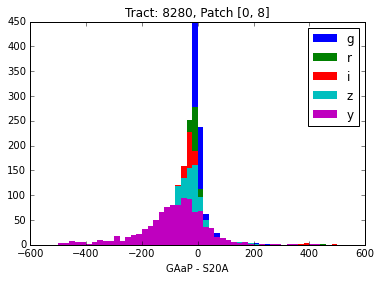

In [14]:
plt.hist(gaapCat_matched["g_gaapPsfFlux"] - s20aCat_matched["g_psfflux_flux"], bins = 50, range = (-500,500),
        ec = "None", label = "g")
plt.hist(gaapCat_matched["r_gaapPsfFlux"] - s20aCat_matched["r_psfflux_flux"], bins = 50, range = (-500,500),
        ec = "None", label = "r")
plt.hist(gaapCat_matched["i_gaapPsfFlux"] - s20aCat_matched["i_psfflux_flux"], bins = 50, range = (-500,500),
        ec = "None", label = "i")
plt.hist(gaapCat_matched["z_gaapPsfFlux"] - s20aCat_matched["z_psfflux_flux"], bins = 50, range = (-500,500),
        ec = "None", label = "z")
plt.hist(gaapCat_matched["y_gaapPsfFlux"] - s20aCat_matched["y_psfflux_flux"], bins = 50, range = (-500,500),
        ec = "None", label = "y")
plt.xlabel("GAaP - S20A")
plt.title(f"Tract: {tract}, Patch {patch}")
plt.legend()
plt.show()

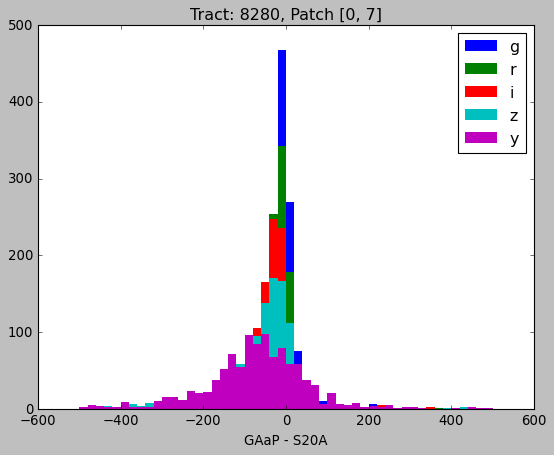

In [23]:
plt.hist(gaapCat_matched["g_gaapPsfFlux"] - s20aCat_matched["g_psfflux_flux"], bins = 50, range = (-500,500),
        ec = "None", label = "g")
plt.hist(gaapCat_matched["r_gaapPsfFlux"] - s20aCat_matched["r_psfflux_flux"], bins = 50, range = (-500,500),
        ec = "None", label = "r")
plt.hist(gaapCat_matched["i_gaapPsfFlux"] - s20aCat_matched["i_psfflux_flux"], bins = 50, range = (-500,500),
        ec = "None", label = "i")
plt.hist(gaapCat_matched["z_gaapPsfFlux"] - s20aCat_matched["z_psfflux_flux"], bins = 50, range = (-500,500),
        ec = "None", label = "z")
plt.hist(gaapCat_matched["y_gaapPsfFlux"] - s20aCat_matched["y_psfflux_flux"], bins = 50, range = (-500,500),
        ec = "None", label = "y")
plt.xlabel("GAaP - S20A")
plt.title(f"Tract: {tract}, Patch {patch}")
plt.legend()
plt.show()

Text(0.5, 1.0, 'r-band')

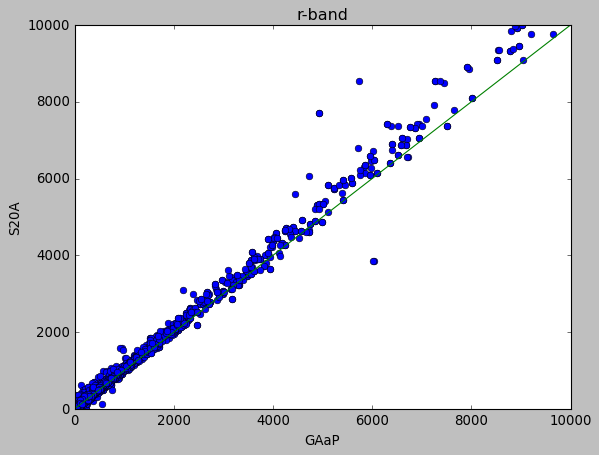

In [52]:
plt.plot(gaapCat_matched["r_gaapPsfFlux"],s20aCat_matched["r_psfflux_flux"], "o")

plt.xlim(0,10000)
plt.ylim(0,10000)

plt.plot(plt.xlim(), plt.xlim())
plt.ylabel("S20A")
plt.xlabel("GAaP")
plt.title("r-band")

In [32]:
s20aCat_matched

object_id,skymap_id,ra,dec,m_g_blendedness_abs,m_r_blendedness_abs,m_i_blendedness_abs,m_z_blendedness_abs,m_y_blendedness_abs,m_g_blendedness_flag,m_r_blendedness_flag,m_i_blendedness_flag,m_z_blendedness_flag,m_y_blendedness_flag,g_apertureflux_10_flux,g_apertureflux_10_flag,r_apertureflux_10_flux,r_apertureflux_10_flag,i_apertureflux_10_flux,i_apertureflux_10_flag,z_apertureflux_10_flux,z_apertureflux_10_flag,y_apertureflux_10_flux,y_apertureflux_10_flag,g_psfflux_flux,r_psfflux_flux,i_psfflux_flux,z_psfflux_flux,y_psfflux_flux
int64,int32,float64,float64,float32,float32,float32,float32,float32,bool,bool,bool,bool,bool,float32,bool,float32,bool,float32,bool,float32,bool,float32,bool,float32,float32,float32,float32,float32
36438803186990948,82850706,38.28506466932066,-6.405253329432761,0.00045610106,0.0011077408,0.0021859112,0.00015090872,0.0046450854,False,False,False,False,False,27245.145,False,83031.0,False,165908.1,False,236597.02,False,191497.98,False,53310.61,160120.39,257358.28,361957.28,380917.0
36438803186992075,82850706,38.315865992169165,-6.369758460394287,0.23211868,0.5249696,0.32359567,0.14272606,0.44508427,True,False,False,True,False,59932.188,False,91499.9,False,38442.105,False,139278.25,False,125250.25,False,104933.91,174163.81,56287.332,204388.0,243487.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36438803186982602,82850706,38.32138133431247,-6.247442879951706,0.0,--,--,0.0,0.0,False,True,True,False,True,72.54944,False,61.618916,False,35.98897,False,124.062454,False,37.210335,False,109.55302,74.62169,83.826004,154.03572,23.07544
36438803186981156,82850706,38.21902577802349,-6.246500129024247,0.0,0.0,--,--,--,False,False,True,True,True,16.56722,False,104.40673,False,114.63371,False,103.763916,False,120.64929,False,47.66989,148.21626,141.81854,137.25996,198.17755
36438803186996766,82850706,38.26412027309625,-6.229054826316379,0.16460755,--,0.43515766,--,--,False,True,False,True,True,61.116936,False,48.212822,False,32.238674,False,40.056976,False,-27.57705,False,147.01758,124.76384,55.8538,41.548576,-14.499943
